In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, datetime
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# %matplotlib inline

In [2]:
df = pd.read_csv('SBAnational.csv')
df

/tmp/ipykernel_103850/3498453600.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SBAnational.csv')


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,...,0,N,NaN,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00"
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,...,Y,N,NaN,31-Oct-97,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00"
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,27-Feb-97,1997,...,N,N,NaN,30-Sep-97,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00"
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,...,N,Y,8-Mar-00,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00"


In [59]:
df['FranchiseCode'][df['FranchiseCode']!='No']='Yes'
df['FranchiseCode'].value_counts()

FranchiseCode
No     847389
Yes     51775
Name: count, dtype: int64

In [63]:
df_2 = df.copy()

#Création de la colonne categorie activité
df_2['cat_activites'] = df['NAICS'].map(lambda x: str(x)[:2])

#Remplace les années avec 1976A par 1976 et passage en INT

df_2.replace('1976A',1976, inplace= True)
df_2['ApprovalFY'] = pd.to_numeric(df_2['ApprovalFY'])

# supprime le dollar et formate
df_2['SBA_loan_float'] = df_2['SBA_Appv'].map(lambda x : float(x[1:].replace(',','')))
df_2['bank_loan_float'] = df_2['GrAppv'].map(lambda x : float(x[1:].replace(',','')))
df_2['DisbursementGross'] = df_2['DisbursementGross'].map(lambda x : float(x[1:].replace(',','')))
df_2['BalanceGross'] = df_2['BalanceGross'].map(lambda x : float(x[1:].replace(',','')))

# Nettoyage de la colonne lowdoc le programme a été créé en 1993 avec les condtions d'être en dessous de 150000 dollars de prêt
df_2['LowDoc'] = df_2.apply(
    lambda row: row['LowDoc'] if row['LowDoc'] in ['Y', 'N']
    else ('N' if row['ApprovalFY'] < 1993 else ('N' if row['bank_loan_float'] > 150000 else 'Y')), axis=1)


# Formatage et de nettoyage de la colonne Approuval Date
# Modifier les années en fonction de la condition
df_2['ApprovalDate'] = df_2['ApprovalDate'].map(
    lambda x: x.replace(x[-3:], '-19' + x[-2:]) if int(x[-2:]) >= 50 else x.replace(x[-3:], '-20' + x[-2:])
)
df_2['ApprovalDate'] = pd.to_datetime(df_2['ApprovalDate'])

#Impute la valeur MIS_Status selon la valeur ChgOffDate (S'il y a une date de défaut, c'est que le prêt n'a pas été remboursé dans son entierté.)
df_2.loc[df_2["MIS_Status"].isna(), "MIS_Status"] = df_2["ChgOffDate"].notna().map({True: "CHGOFF", False: "P I F"})

# retirer les null dans state

#Trie le DataFrame par zip code en ordre ascendant
df_sorted = df_2.sort_values(by='Zip')

# Regroupe le DataFrame par Zip code
grouped = df_sorted.groupby('Zip')# Regroupe le DataFrame par Zip code
#Remplace les cellules State vides par la valeur State non-nulle correspondante dans chaque groupe
df_sorted['State'] = grouped['State'].fillna(method='ffill')
df_2 = df_sorted.sort_index()

#Remplace la dernière cellule vide par l'état AP pour base américaine
df_2 = df_2.fillna({'State':'AP'})
annee_crise = [1960,1961,1969,1970,1973,1974,1980,1981,1982,2000,2001,2007,2008]
df_2['crisis'] = df['ApprovalFY'].apply(lambda x : 1 if x in annee_crise else 0)

# #remplace franchise code par une catégorie
# df_2['FranchiseCode']=df_2['FranchiseCode'].apply(lambda x:'No' if x==0 or x==1 else 'Yes')


df_2.to_csv('dataset.csv', index = False)
# df_2.columns

/tmp/ipykernel_103850/2676648975.py:41: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_sorted['State'] = grouped['State'].fillna(method='ffill')
/tmp/ipykernel_103850/2676648975.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sorted['State'] = grouped['State'].fillna(method='ffill')
/tmp/ipykernel_103850/2676648975.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sorted['State'] = grouped['State'].fillna(method='ffill')


In [53]:
#Trie le DataFrame par zip code en ordre ascendant
df_sorted = df_2.sort_values(by='Zip')

# Regroupe le DataFrame par Zip code
grouped = df_sorted.groupby('Zip')# Regroupe le DataFrame par Zip code


# Remplace les cellules State vides par la valeur State non-nulle correspondante dans chaque groupe
df_sorted['State'] = grouped['State'].fillna(method='ffill')
df_2 = df_sorted.sort_index()

In [4]:
df['MIS_Status'].nunique()

2

In [5]:
df['MIS_Status'].isna().sum()

np.int64(1997)

In [6]:
df['MIS_Status'].value_counts()

MIS_Status
P I F     739609
CHGOFF    157558
Name: count, dtype: int64

In [7]:
(df['MIS_Status'].value_counts()['CHGOFF']) / len(df)

np.float64(0.17522721105382333)

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
df_2=df.copy()

In [10]:
df_2.loc[df_2['NewExist'].isna()]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
395231,3808405000,J.W.Chipping Corp,BETHLEHEM,NH,3574,FIRST COLEBROOK BANK,NH,423310,15-Dec-09,2010,72,7,NaN,0,7,0,2,N,N,NaN,15-Dec-09,"$117,000.00",$0.00,P I F,$0.00,"$117,000.00","$99,450.00"
399884,3854945010,D & R Foods Inc.,INDIANOLA,MS,38751,TRUSTMARK NATIONAL BANK,MS,445110,13-Jan-10,2010,38,20,NaN,0,20,0,2,N,N,NaN,1-Feb-10,"$150,000.00",$0.00,P I F,$0.00,"$150,000.00","$135,000.00"
400052,3856405005,"Luna Design Group, Inc.",LYNNFIELD,MA,1940,PEOPLE'S UNITED BANK,CT,541310,14-Jan-10,2010,73,4,NaN,0,4,0,1,N,N,NaN,25-Mar-10,"$25,000.00",$0.00,P I F,$0.00,"$25,000.00","$25,000.00"
400203,3857955008,Lisbon Market Inc,LISBON,OH,44432,THE CITIZENS SAVINGS BANK,OH,445110,15-Jan-10,2010,84,0,NaN,25,0,0,1,N,N,NaN,15-Jan-10,"$350,000.00",$0.00,P I F,$0.00,"$350,000.00","$175,000.00"
400300,3858915009,"George F. Gales, Jr. MD",QUINCY,MA,2170,EASTERN BANK,MA,621111,15-Jan-10,2010,84,2,NaN,0,2,0,1,Y,N,NaN,1-Apr-10,"$52,395.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470308,4540125002,"GG&M, LLC",GENESEE,ID,83832,ZIONS FIRST NATIONAL BANK,UT,424410,10-Feb-11,2011,0,2,NaN,1,3,0,1,Y,N,28-Feb-13,10-Feb-11,"$21,176.00",$0.00,CHGOFF,"$12,842.00","$15,000.00","$7,500.00"
471939,4553585010,"MORGAN VENTURES, INC",COLLINS,MS,39428,COVINGTON COUNTY BANK,MS,722110,23-Feb-11,2011,48,10,NaN,0,10,0,1,N,N,NaN,23-Feb-11,"$20,500.00",$0.00,P I F,$0.00,"$20,500.00","$17,425.00"
498244,4820745005,Goodcare LLC,DELL RAPIDS,SD,57022,MINNWEST BANK,SD,624310,12-Aug-11,2011,84,19,NaN,19,19,0,1,T,N,NaN,19-Aug-11,"$129,717.00",$0.00,P I F,$0.00,"$100,000.00","$50,000.00"
512594,4957935004,"912 Enterprises Franchising, I",CRANBERRY TWP,PA,16066,FIRST COMMONWEALTH BANK,PA,311520,16-Nov-11,2012,60,10,NaN,15,10,0,1,N,N,NaN,16-Nov-11,"$43,000.00",$0.00,P I F,$0.00,"$43,000.00","$21,500.00"


In [11]:
df_newE = df_2['NewExist'].astype('category')
df_mis = df_2['MIS_Status'].astype('category')

In [12]:
contingency_table = pd.crosstab(df_newE, df_mis)
contingency_table

MIS_Status,CHGOFF,P I F
NewExist,,
0.0,63,965
1.0,110114,533332
2.0,47367,205192


In [13]:
df_2['NAICS'].value_counts()

NAICS
0         201948
722110     27989
722211     19448
811111     14585
621210     14048
           ...  
212324         1
312210         1
925120         1
112420         1
311311         1
Name: count, Length: 1312, dtype: int64

In [14]:
df_2[df_2['NAICS'] == 0]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"
6,1000093009,MIDDLE ATLANTIC SPORTS CO INC,UNION,NJ,7083,WELLS FARGO BANK NATL ASSOC,SD,0,2-Jun-80,1980,45,45,2.0,0,0,0,0,N,N,24-Jun-91,22-Jul-80,"$600,000.00",$0.00,CHGOFF,"$208,959.00","$600,000.00","$499,998.00"
9,1000124001,INTEXT BUILDING SYS LLC,GLASTONBURY,CT,6073,WEBSTER BANK NATL ASSOC,CT,0,28-Feb-97,1997,84,3,2.0,0,0,1,0,N,Y,NaN,30-Apr-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00"
13,1000154010,"ORCHARD CAFE & BAKERY, INC.",SLATERSVILLE,RI,2876,CITIZENS BANK NATL ASSOC,RI,0,28-Feb-97,1997,120,2,2.0,0,0,1,0,N,N,NaN,31-May-97,"$370,000.00",$0.00,P I F,$0.00,"$370,000.00","$277,500.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899153,9995413002,NORTH SHORE FLORAL,WOODBURY,NY,11797,FLUSHING BANK,NY,0,27-Feb-97,1997,119,5,1.0,0,0,1,0,0,N,7-Jul-04,31-May-97,"$142,000.00",$0.00,CHGOFF,$0.00,"$142,000.00","$106,500.00"
899154,9995423005,"LITWIN LIVERY SERVICES, INC.",CAMPBELL,OH,44405,JPMORGAN CHASE BANK NATL ASSOC,IL,0,27-Feb-97,1997,60,1,1.0,0,0,1,0,0,N,NaN,30-Sep-97,"$10,000.00",$0.00,P I F,$0.00,"$10,000.00","$5,000.00"
899158,9995563001,SHADES WINDOW TINTING AUTO ALA,IRVING,TX,75062,LOANS FROM OLD CLOSED LENDERS,DC,0,27-Feb-97,1997,84,5,2.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$79,000.00",$0.00,P I F,$0.00,"$79,000.00","$63,200.00"
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,60,6,1.0,0,0,1,0,N,Y,8-Mar-00,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00"


In [15]:
from ydata_profiling import ProfileReport

In [16]:
# report = ProfileReport(df)
# report.to_file('report.html')

In [17]:
df['ApprovalFY'].value_counts()

ApprovalFY
2006    76040
2007    71876
2003    58193
2005    52912
1995    45758
        ...  
1965        1
1967        1
1968        1
1967        1
1968        1
Name: count, Length: 70, dtype: int64

In [18]:
from datetime import datetime

df_2['dif_days_aproved_received'] = pd.to_datetime(df_2['DisbursementDate']) - pd.to_datetime(df_2['ApprovalDate'])

df_2

/tmp/ipykernel_103850/984317455.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2['dif_days_aproved_received'] = pd.to_datetime(df_2['DisbursementDate']) - pd.to_datetime(df_2['ApprovalDate'])
/tmp/ipykernel_103850/984317455.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2['dif_days_aproved_received'] = pd.to_datetime(df_2['DisbursementDate']) - pd.to_datetime(df_2['ApprovalDate'])


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,dif_days_aproved_received
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",730 days
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",92 days
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",306 days
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00",122 days
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00",75 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,60,6,1.0,0,0,1,0,0,N,NaN,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00",215 days
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,60,6,1.0,0,0,1,0,Y,N,NaN,31-Oct-97,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00",246 days
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,27-Feb-97,1997,108,26,1.0,0,0,1,0,N,N,NaN,30-Sep-97,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00",215 days
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,60,6,1.0,0,0,1,0,N,Y,8-Mar-00,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00",32 days


In [19]:
df_2['ratio_SBA_bank'] = df_2['SBA_Appv'].map(lambda x : float(x[1:].replace(',',''))) / df_2['GrAppv'].map(lambda x : float(x[1:].replace(',','')))
df_2

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,dif_days_aproved_received,ratio_SBA_bank
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",730 days,0.80
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",92 days,0.80
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",306 days,0.75
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00",122 days,0.80
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00",75 days,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,27-Feb-97,1997,60,6,1.0,0,0,1,0,0,N,NaN,30-Sep-97,"$70,000.00",$0.00,P I F,$0.00,"$70,000.00","$56,000.00",215 days,0.80
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,27-Feb-97,1997,60,6,1.0,0,0,1,0,Y,N,NaN,31-Oct-97,"$85,000.00",$0.00,P I F,$0.00,"$85,000.00","$42,500.00",246 days,0.50
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,27-Feb-97,1997,108,26,1.0,0,0,1,0,N,N,NaN,30-Sep-97,"$300,000.00",$0.00,P I F,$0.00,"$300,000.00","$225,000.00",215 days,0.75
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,0,27-Feb-97,1997,60,6,1.0,0,0,1,0,N,Y,8-Mar-00,31-Mar-97,"$75,000.00",$0.00,CHGOFF,"$46,383.00","$75,000.00","$60,000.00",32 days,0.80


In [20]:
#NB EST LA TABLE D'un group by entre mis status et newexist au final la donnée sur newexiste n'est pas pertinente

nb_mis = df_2.groupby(['MIS_Status', 'NewExist'])['NewExist'].count().reset_index(name='count')


nb_mis['ratio'] = nb_mis.apply(lambda row: 
                               row['count'] / nb_mis[nb_mis['MIS_Status'] == 'CHGOFF']['count'].sum() 
                               if row['MIS_Status'] == 'CHGOFF' 
                               else row['count'] / nb_mis[nb_mis['MIS_Status'] == 'P I F']['count'].sum(), 
                               axis=1)

nb_mis

,MIS_Status,NewExist,count,ratio
0,CHGOFF,0.0,63,0.000400
1,CHGOFF,1.0,110114,0.698941
2,CHGOFF,2.0,47367,0.300659
3,P I F,0.0,965,0.001305
4,P I F,1.0,533332,0.721217
5,P I F,2.0,205192,0.277478


In [21]:
df_2['ApprovalFY'].unique()

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1962, 1982, 1965, 1966, 1983, 1973, 1984, 2007,
       1985, 1986, 1987, 2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010,
       1967, 2011, 1992, 1993, 2002, 2012, 2013, 1994, 2014, 1975, 1977,
       1976, 1968, '2004', '1994', '1979', '1976', '1967', '1975', '1974',
       '1977', '1981', '1982', '1983', '1984', '1978', '1980', '1968',
       '1976A', '1969', '1995', '1970', '2005', '1996', '1971', 1996,
       1971], dtype=object)

In [22]:
df_2.replace('1976A',1976, inplace= True)
df_2['ApprovalFY'] = pd.to_numeric(df_2['ApprovalFY'])

/tmp/ipykernel_103850/2603824373.py:1: FutureWarning: 'A' is deprecated and will be removed in a future version. Please use 'Y' instead of 'A'.
  df_2.replace('1976A',1976, inplace= True)


In [23]:
df_2_annee_MIS = df_2[['ApprovalFY', 'MIS_Status']]


df_2_annee_MIS_group = df_2_annee_MIS.groupby(['ApprovalFY','MIS_Status']).size()
df_2_annee_MIS_group_df = pd.DataFrame(df_2_annee_MIS_group).reset_index()

df_2_annee_MIS_group_df.columns = ['years', 'status','nb']
df_2_annee_MIS_group_df
# Définir les intervalles de gravité des crises économiques
bins = [1968, 1972, 1979, 1991, 1997, 2002, 2008, 2014]
labels = ['Faible', 'Modéré', 'Moins grave', 'Modéré', 'Grave', 'Faible', 'Très grave']

# Appliquer pd.cut() pour classer les années selon les intervalles
df_2_annee_MIS_group_df['Crise Économique'] = pd.cut(df_2_annee_MIS_group_df['years'], bins=bins, labels=labels, right=False, ordered=False)

pd.set_option('display.max_rows', 120)
df_2_annee_MIS_group_df.head(118)

,years,status,nb,Crise Économique
0,1966,CHGOFF,1,NaN
1,1968,CHGOFF,1,Faible
2,1969,CHGOFF,2,Faible
3,1969,P I F,1,Faible
4,1970,CHGOFF,7,Faible
5,1970,P I F,1,Faible
6,1971,CHGOFF,18,Faible
7,1972,CHGOFF,21,Modéré
8,1972,P I F,4,Modéré
9,1973,CHGOFF,45,Modéré


In [24]:
sns.scatterplot(x = "years", 
                y = "nb", 
                data = df_2_annee_MIS_group_df, 
                hue = "status")

<Axes: xlabel='years', ylabel='nb'>

In [25]:
# df_2_annee_MIS_group_df['PIF_proportions'] = df_2_annee_MIS_group_df['status']
total_per_year = df_2_annee_MIS_group_df.groupby('years')['nb'].transform('sum')

# Calculer la proportion pour chaque ligne
df_2_annee_MIS_group_df['status_proportion'] = df_2_annee_MIS_group_df['nb'] / total_per_year

# Afficher le DataFrame avec la nouvelle colonne
print(df_2_annee_MIS_group_df)

    years  status     nb Crise Économique  status_proportion
0    1966  CHGOFF      1              NaN           1.000000
1    1968  CHGOFF      1           Faible           1.000000
2    1969  CHGOFF      2           Faible           0.666667
3    1969   P I F      1           Faible           0.333333
4    1970  CHGOFF      7           Faible           0.875000
5    1970   P I F      1           Faible           0.125000
6    1971  CHGOFF     18           Faible           1.000000
7    1972  CHGOFF     21           Modéré           0.840000
8    1972   P I F      4           Modéré           0.160000
9    1973  CHGOFF     45           Modéré           0.918367
10   1973   P I F      4           Modéré           0.081633
11   1974  CHGOFF     40           Modéré           0.952381
12   1974   P I F      2           Modéré           0.047619
13   1975  CHGOFF     26           Modéré           0.896552
14   1975   P I F      3           Modéré           0.103448
15   1976  CHGOFF     78

In [26]:
df_2_PIF = df_2_annee_MIS_group_df[df_2_annee_MIS_group_df['status']=='P I F']

In [27]:
df_2_PIF

,years,status,nb,Crise Économique,status_proportion
3,1969,P I F,1,Faible,0.333333
5,1970,P I F,1,Faible,0.125000
8,1972,P I F,4,Modéré,0.160000
10,1973,P I F,4,Modéré,0.081633
12,1974,P I F,2,Modéré,0.047619
14,1975,P I F,3,Modéré,0.103448
16,1976,P I F,5,Modéré,0.060241
18,1977,P I F,9,Modéré,0.065693
20,1978,P I F,10,Modéré,0.041841
22,1979,P I F,17,Moins grave,0.048711


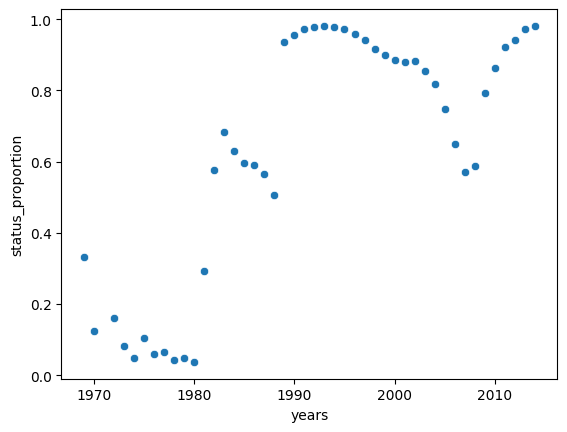

In [50]:

sns.scatterplot(data= df_2_PIF, x='years', y='status_proportion')
plt.show()

In [41]:
df_2_sum_years = df_2.groupby('ApprovalFY')['bank_loan_float'].sum()
df_2_sum_years = pd.DataFrame(df_2_sum_years).reset_index()
df_2_sum_years.columns = ['years', 'total_loan_bank']

sns.scatterplot(x = "years", 
                y = "total_loan_bank", 
                data = df_2_sum_years, 
                #hue = "status"
                )

KeyError: 'Column not found: bank_loan_float'

In [50]:
df_2['LowDoc'][(df_2['LowDoc'] != 'Y') & (df_2['LowDoc']!= 'N')].unique()

#après nettoyage en fonction de l'année et de la valeur du prêt, plus de valeurs autres que Y ou N

array([], dtype=object)

In [51]:
df_2['LowDoc'].unique()

array(['Y', 'N'], dtype=object)

In [ ]:
# Assurez-vous que les colonnes 'Lowdoc' et 'MIS_Status' sont de type catégoriel
low_d= df_2['LowDoc'].astype('category')
status_d= df_2['MIS_Status'].astype('category')

# Créez un tableau de contingence entre les deux variables
contingency_table = pd.crosstab(low_d, status_d)

contingency_table

MIS_Status,CHGOFF,P I F
LowDoc,,
N,146306,636927
Y,11252,102682


In [59]:
contingency_table['proportions_PIF']=(contingency_table['P I F'])  / (contingency_table['CHGOFF']+contingency_table['P I F'])

In [60]:
contingency_table

MIS_Status,CHGOFF,P I F,proportions_PIF
LowDoc,,,
N,146306,636927,0.813202
Y,11252,102682,0.901241


In [63]:
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Statistique Chi-2:", chi2)
print("Degrés de liberté:", dof)
print("P-value:", p)
print("Tableau des valeurs attendues :\n", expected)

Statistique Chi-2: 5324.413151338364
Degrés de liberté: 1
P-value: 0.0
Tableau des valeurs attendues :
 [[137549.2244075 645683.7755925]
 [ 20008.7755925  93925.2244075]]


### CHI 2 ET ANOVA SUR LA VARIABLE MIS STATUS

In [66]:
df_2_chi2 = df_2[['State', 'NAICS','UrbanRural','LowDoc','Bank','RevLineCr','FranchiseCode','NewExist','cat_activites','MIS_Status']]

for column in df_2_chi2.columns:
    df_var = df_2_chi2[column].astype('category')
    df_cible = df_2_chi2['MIS_Status'].astype('category')
    contingency_table = pd.crosstab(df_var, df_cible)
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    p_crit = stats.chi2.ppf(0.95, dof)
    print(f'le résultat pour {column}')
    print("Statistique Chi-2:", chi2)
    print("Degrés de liberté:", dof)
    print("valeur critique:", p_crit)

    print("P-value:", p)
    print("Tableau des valeurs attendues :\n", expected)
    print('')
    print('================================================================================')

le résultat pour State
Statistique Chi-2: 11163.87470891073
Degrés de liberté: 50
valeur critique: 67.5048065495412
P-value: 0.0
Tableau des valeurs attendues :
 [[   422.00900626   1980.99099374]
 [  1468.16283492   6891.83716508]
 [  1112.18603272   5220.81396728]
 [  3095.08394768  14528.91605232]
 [ 22915.98468936 107572.01531064]
 [  3617.37058298  16980.62941702]
 [  2129.71419845   9997.28580155]
 [   283.27113071   1329.72886929]
 [   385.12931782   1807.87068218]
 [  7234.0386957   33957.9613043 ]
 [  3911.35438509  18360.64561491]
 [   633.4525533    2973.5474467 ]
 [  2104.95212193   9881.04787807]
 [  1667.66438761   7828.33561239]
 [  5197.22618859  24396.77381141]
 [  2472.51968335  11606.48031665]
 [  2011.69919546   9443.30080454]
 [  1355.76759397   6364.23240603]
 [  1680.66008734   7889.33991266]
 [  4406.59591553  20685.40408447]
 [  2328.51328089  10930.48671911]
 [  1042.64147738   4894.35852262]
 [  3598.93073876  16894.06926124]
 [  4277.86824113  20081.13175887

In [67]:
df_loan_mis = pd.crosstab(df_2['bank_loan_float'],df_mis)
df_loan_mis

MIS_Status,CHGOFF,P I F
bank_loan_float,,
1000.0,3,52
1200.0,0,1
1500.0,1,8
1600.0,0,1
1700.0,0,1
...,...,...
4908500.0,0,1
4950000.0,0,1
4991700.0,0,1


In [68]:
df_2_anova = df_2[['CreateJob', 'RetainedJob','DisbursementGross','Term','BalanceGross','bank_loan_float','SBA_loan_float','MIS_Status']]

for column in df_2_anova.columns:
    df_cible = df_2_anova['MIS_Status'].astype('category')
    contingency_table = pd.crosstab(df_2_anova[column],df_cible )
    stat_anova, p_value = stats.f_oneway(contingency_table['CHGOFF'],contingency_table['P I F'])

    print(f'le résultat pour {column}')
    print("Statistique f:", stat_anova)
    # print("Degrés de liberté:", dof)
    # print("valeur critique:", p_crit)

    print("P-value:", p_value)
    # print("Tableau des valeurs attendues :\n", expected)
    print('')
    print('================================================================================')

le résultat pour CreateJob
Statistique f: 1.151565171632204
P-value: 0.2837499366902255

le résultat pour RetainedJob
Statistique f: 1.9810024441490153
P-value: 0.15972124668399693

le résultat pour DisbursementGross
Statistique f: 67.63026752111743
P-value: 1.98201837088503e-16

le résultat pour Term
Statistique f: 4.501241609006526
P-value: 0.03416887720226397

le résultat pour BalanceGross
Statistique f: 0.592461107325052
P-value: 0.4479143613267187

le résultat pour bank_loan_float
Statistique f: 32.93169959600842
P-value: 9.607642141413845e-09

le résultat pour SBA_loan_float
Statistique f: 66.36789172960822
P-value: 3.7972682315413563e-16

le résultat pour MIS_Status
Statistique f: 0.5924381193985884
P-value: 0.5219566314902659



### Analyse de REVLINECR


In [69]:
df_2_anova = df_2[['CreateJob', 'RetainedJob','DisbursementGross','Term','BalanceGross','bank_loan_float','SBA_loan_float','RevLineCr']]
df_cible = df_2_anova['RevLineCr'].astype('category')


for column in df_2_anova.columns:
    df_cible = df_2_anova['RevLineCr'].astype('category')
    contingency_table = pd.crosstab(df_2_anova[column],df_cible )
    stat_anova, p_value = stats.f_oneway(contingency_table["Y"],contingency_table["N"],contingency_table["T"],contingency_table["0"])

    print(f'le résultat pour {column}')
    print("Statistique f:", stat_anova)
    # print("Degrés de liberté:", dof)
    # print("valeur critique:", p_crit)

    print("P-value:", p_value)
    # print("Tableau des valeurs attendues :\n", expected)
    print('')
    print('================================================================================')

le résultat pour CreateJob
Statistique f: 0.7378554669141997
P-value: 0.5295498168302255

le résultat pour RetainedJob
Statistique f: 1.0403076178075414
P-value: 0.37369713793143705

le résultat pour DisbursementGross
Statistique f: 38.980742745496364
P-value: 3.539842318830961e-25

le résultat pour Term
Statistique f: 3.741179138750476
P-value: 0.010747990998897946

le résultat pour BalanceGross
Statistique f: 0.39339693642608486
P-value: 0.7582231512240599

le résultat pour bank_loan_float
Statistique f: 18.440195523054186
P-value: 5.915087075709745e-12

le résultat pour SBA_loan_float
Statistique f: 26.91923209119849
P-value: 2.133219649403041e-17

le résultat pour RevLineCr
Statistique f: 0.3933862313342988
P-value: 0.7581477950490004



## que le disbursement gross qui est significatif  ->>> pourquoi pas le bank_loan_float??

In [70]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Sélection des colonnes nécessaires
df_2_anova = df_2[['CreateJob', 'RetainedJob', 'DisbursementGross', 'Term', 'BalanceGross', 'bank_loan_float', 'SBA_loan_float', 'RevLineCr']]
df_2_anova = df_2_anova[df_2_anova['RevLineCr'].isin(['Y', 'N', 'T', '0'])]
df_2_anova
# S'assurer que 'RevLineCr' est une variable catégorielle
df_2_anova['RevLineCr'] = df_2_anova['RevLineCr'].astype('category')

# Appliquer le test de Tukey
tukey_oneway = pairwise_tukeyhsd(endog=df_2_anova['Term'], groups=df_2_anova['RevLineCr'], alpha=0.05)

# Afficher les résultats

print('Tukey poour Term')
print(tukey_oneway.summary())

# Appliquer le test de Tukey
tukey_oneway = pairwise_tukeyhsd(endog=df_2_anova['bank_loan_float'], groups=df_2_anova['RevLineCr'], alpha=0.05)

print('Tukey poour bank_loan_float')
print(tukey_oneway.summary())


# Appliquer le test de Tukey
tukey_oneway = pairwise_tukeyhsd(endog=df_2_anova['BalanceGross'], groups=df_2_anova['RevLineCr'], alpha=0.05)

print('Tukey poour BalanceGross')
print(tukey_oneway.summary())


Tukey poour Term
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      N  -0.9636   0.0  -1.4382   -0.489   True
     0      T  -62.194   0.0 -63.7731  -60.615   True
     0      Y -65.3442   0.0 -65.9084   -64.78   True
     N      T -61.2304   0.0 -62.7923 -59.6686   True
     N      Y -64.3806   0.0 -64.8946 -63.8666   True
     T      Y  -3.1502   0.0  -4.7415  -1.5588   True
-----------------------------------------------------
Tukey poour bank_loan_float
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1 group2   meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------
     0      N   -27657.438    0.0  -29410.1429  -25904.7331   True
     0      T -190382.5529    0.0 -196213.9792 -184551.1265   True
     0      Y -191073.7771    0.0 -193157.2222 -188990.3321   True
     N      T